In [1]:
import cv2

import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from frcnn_tools.engine import train_one_epoch, evaluate
import utils
from rcnn_utils import *

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

2.0.1+cu117
0.15.2+cu117


In [2]:
dataset_location = utils.load_rf_data(8)
dataset_location

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.153, to fix: `pip install ultralytics==8.0.134`


Extracting Dataset Version Zip to Football-Player-Detection-8 in yolov8:: 100%|██████████| 115/115 [00:00<00:00, 5599.22it/s]


'/home/mikkel/VSC/football-player-detection/Football-Player-Detection-8'

In [3]:
from rcnn_dataset import Dataset

batch_size = 4

transforms = A.Compose([ToTensorV2(p=1.0)], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

train_dataset = Dataset(dataset_location, dataset_type="train", imgsz=640, transforms=transforms)
val_dataset = Dataset(dataset_location, dataset_type="val", imgsz=640, transforms=transforms)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=utils.collate_fn
)

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 1 + 4 # background + 4 classes

# load model pretrained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pretrained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

params  = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0005, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.


In [5]:
epochs = 25

for epoch in range(epochs):

    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)

    lr_scheduler.step()

    evaluate(model, val_loader, device=device)

Epoch: [0]  [ 0/12]  eta: 0:00:29  lr: 0.000046  loss: 3.7848 (3.7848)  loss_classifier: 1.7964 (1.7964)  loss_box_reg: 0.3260 (0.3260)  loss_objectness: 1.4422 (1.4422)  loss_rpn_box_reg: 0.2201 (0.2201)  time: 2.4852  data: 0.2543  max mem: 7565
Epoch: [0]  [11/12]  eta: 0:00:01  lr: 0.000500  loss: 1.2772 (1.8416)  loss_classifier: 0.3935 (0.6862)  loss_box_reg: 0.5569 (0.5691)  loss_objectness: 0.1168 (0.3865)  loss_rpn_box_reg: 0.1963 (0.1998)  time: 1.0779  data: 0.0242  max mem: 7898
Epoch: [0] Total time: 0:00:12 (1.0791 s / it)
creating index...
index created!
Test:  [0/6]  eta: 0:00:01  model_time: 0.1184 (0.1184)  evaluator_time: 0.0075 (0.0075)  time: 0.2257  data: 0.0992  max mem: 7898
Test:  [5/6]  eta: 0:00:00  model_time: 0.1044 (0.1067)  evaluator_time: 0.0064 (0.0067)  time: 0.1313  data: 0.0175  max mem: 7898
Test: Total time: 0:00:00 (0.1363 s / it)
Averaged stats: model_time: 0.1044 (0.1067)  evaluator_time: 0.0064 (0.0067)
Accumulating evaluation results...
DONE (

In [6]:
evaluate(model, val_loader, device)

creating index...
index created!
Test:  [0/6]  eta: 0:00:01  model_time: 0.1155 (0.1155)  evaluator_time: 0.0061 (0.0061)  time: 0.2387  data: 0.1164  max mem: 7898
Test:  [5/6]  eta: 0:00:00  model_time: 0.1144 (0.1143)  evaluator_time: 0.0055 (0.0057)  time: 0.1407  data: 0.0201  max mem: 7898
Test: Total time: 0:00:00 (0.1463 s / it)
Averaged stats: model_time: 0.1144 (0.1143)  evaluator_time: 0.0055 (0.0057)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.336
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.

In [7]:
torch.save(model.state_dict(), 'faster_rcnn.pt')

Inference

In [14]:
inf_model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)

in_features = inf_model.roi_heads.box_predictor.cls_score.in_features

inf_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

inf_model.to(device)

best_model = torch.load('faster_rcnn.pt')
inf_model.load_state_dict(best_model)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.


<All keys matched successfully>

In [15]:
img = cv2.imread(f"{dataset_location}/valid/images/9f4df856_0_mp4-1_jpg.rf.1463a2e74baaa167f9152848d82589b8.jpg")
img.shape

(1080, 1920, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image device: cuda:0
Model device: CUDA


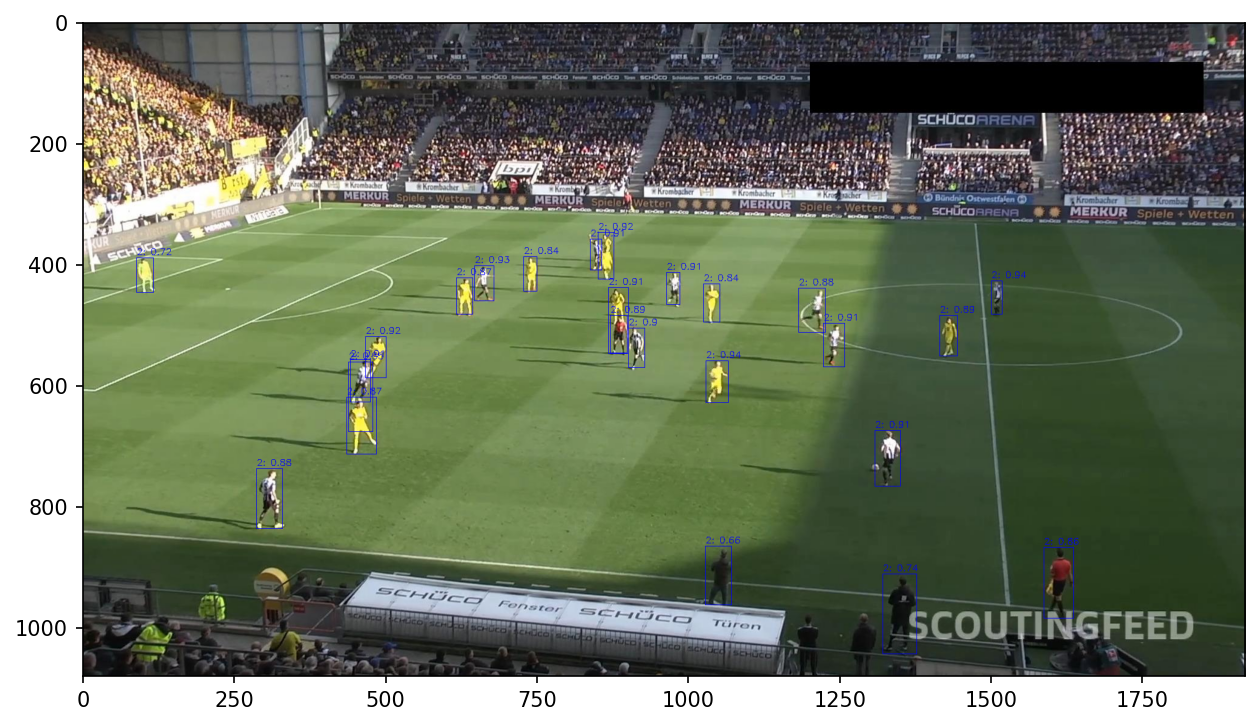

In [17]:
#from rcnn_utils import inference

inference(img, inf_model, device, conf=0.5)